In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA
import numpy as np
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, f1_score, accuracy_score
from hyperopt import fmin, tpe, space_eval, hp, STATUS_OK, Trials
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

from transformers import AutoTokenizer, AutoModel
import torch

from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns

import pandas as pd
import os
import time
from typing import List

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
import torch

from sklearn.model_selection import train_test_split
import torch

from transformers import TrainingArguments, Trainer

import evaluate

from sklearn.utils.class_weight import compute_class_weight

from torch import nn
from transformers import Trainer
import optuna

from sklearn.model_selection import StratifiedKFold

import json

2023-11-23 17:51:52.231198: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 17:51:52.231224: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 17:51:52.231249: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 17:51:52.236858: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 17:51:52.809285: W tensorflow/compiler/

In [3]:

# Senolytic dataset - labelled
senolytics_df = pd.read_csv('list_of_compounds_for_training.csv')
senolytics_df

,Name,senolytic,Library,Source,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,Azaguanine-8,0,Prestwick,Not identified,c12/N=C(\NC(c1nn[nH]2)=O)/N,3.024307,441.024163,7.844935,5.327239,5.327239,...,0,0,0,0,0,0,0,0,0,0.430316
1,Allantoin,0,Prestwick,Not identified,N1C(NC(C1=O)NC(=O)N)=O,2.534439,225.377060,8.430721,5.379445,5.379445,...,0,0,0,0,0,0,0,0,2,0.325138
2,Acetazolamide,0,Prestwick,Not identified,c1(S(=O)(=O)N)sc(nn1)NC(=O)C,2.938691,422.352468,10.060478,6.513019,8.146012,...,1,0,0,0,0,0,0,0,0,0.631859
3,Metformin hydrochloride,0,Prestwick,Not identified,C(NC(=N)N)(=N)N(C)C,3.644486,126.919685,7.439158,5.524564,5.524564,...,0,0,0,0,0,0,0,0,0,0.248785
4,Atracurium besylate,0,Prestwick,Not identified,[N+]1(C(c2c(cc(c(c2)OC)OC)CC1)Cc1cc(c(cc1)OC)O...,0.987040,2158.836594,48.141042,41.328212,41.328212,...,0,0,0,0,0,0,0,4,0,0.038349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518,Curcumin,1,"GPNCL, ENZO","Source 12 - Yousefzadeh et al, 2018",COC1=C(C=CC(=C1)/C=C/C(=O)CC(=O)/C=C/C2=CC(=C(...,1.958861,822.040000,19.811190,15.008030,15.008030,...,0,0,0,0,0,0,0,0,0,0.548123
2519,Dasatinib,1,"Unknown library, see publication source","Source 13 - Zhu et al, 2015",CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...,1.431593,1111.432171,23.371668,18.507135,20.079560,...,0,0,0,0,1,0,0,0,0,0.465717
2520,Navitoclax,1,"Unknown library, see publication source","Source 14 - Zhu et al, 2016",CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...,1.017180,2532.551918,46.408991,36.449290,39.654708,...,1,1,0,0,0,0,0,0,0,0.104649
2521,A1331852,1,"Unknown library, see publication source","Source 15 - Zhu et al, 2017",O=C(NC1=NC(C=CC=C2)=C2S1)C3=C(CN(C4=CC=C(C5=C(...,0.969918,2030.733706,32.569974,26.984648,27.801144,...,0,0,0,0,1,0,0,0,0,0.185260


In [4]:
# Senolytic dataset - test set
test_df = pd.read_csv('list_of_compounds_for_computational_screening.csv')
test_df

,Name,Library,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,(-)-Arctigenin,Selleck,COC1=C(O)C=CC(=C1)CC2C(COC2=O)CC3=CC=C(OC)C(=C...,1.763934,816.314286,19.388541,15.728578,15.728578,13.049575,8.787575,...,0,0,0,0,0,0,0,0,0,0.753438
1,(-)-Blebbistatin,Targetmol 3338,Cc1ccc2N=C3N(CC[C@@]3(O)C(=O)c2c1)c1ccccc1,1.880486,797.989385,15.319626,12.282905,12.282905,10.593172,7.390657,...,0,0,0,0,0,0,0,0,0,0.879020
2,(-)-Borneol,Selleck,CC1(C)C2CCC1(C)C(O)C2,2.396255,185.311799,8.276021,7.723234,7.723234,4.982999,4.663847,...,0,0,0,0,0,0,0,0,0,0.566800
3,(-)-Cotinine,Targetmol 3338,CN1[C@@H](CCC1=O)c1cccnc1,2.236360,309.960601,9.259149,7.603640,7.603640,6.287694,4.444035,...,0,0,0,0,0,0,0,0,0,0.647201
4,(-)-Epicatechin gallate,Selleck,OC1=CC2=C(CC(OC(=O)C3=CC(=C(O)C(=C3)O)O)C(O2)C...,1.721352,1196.568791,23.153972,16.258499,16.258499,15.133938,9.330270,...,0,0,0,0,0,0,0,0,0,0.235487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335,α-Terpineol,Selleck,CC1=CCC(CC1)C(C)(C)O,2.538576,162.201816,8.483128,7.723234,7.723234,4.999019,4.379255,...,0,0,0,0,0,0,0,0,0,0.575260
4336,β-Alanine,Selleck,NCCC(O)=O,2.831257,52.754888,4.991564,3.347026,3.347026,2.770056,1.689533,...,0,0,0,0,0,0,0,0,0,0.475392
4337,β-Caryophyllene,Selleck,CC/1=C\CCC(=C)C2CC(C)(C)C2CC1,2.119623,293.160171,11.052042,10.474691,10.474691,7.004837,6.338317,...,0,0,0,0,0,0,0,0,0,0.500562
4338,β-Elemonic Acid,Targetmol 3338,C\C(C)=C/CC[C@@H]([C@@H]1CC[C@]2(C)C3=C(CC[C@@...,1.695803,903.502499,24.396977,22.144179,22.144179,15.287200,13.412878,...,0,0,0,0,0,0,0,0,0,0.431968


In [7]:
import json

best_trial= {}

best_trial['best_value'] = 0.863304347826087
best_trial['best_params'] = {'learning_rate': 0.0002129544689531246, 'weight_decay': 0.003149550907030126, 'num_train_epochs': 9}
best_trial['best_trial_number'] = 59

with open("best_trial_100_try1.txt", "w") as fp:
    json.dump(best_trial, fp)  # encode dict into JSON
print("Done writing dict into .txt file")

Done writing dict into .txt file


## Training, test sets set up

In [13]:
#Current version
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, labels, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

        # Tokenize the SMILES strings and store them
        self.encodings = self.tokenize_smiles(dataframe['SMILES'].tolist())

        # Store the labels
        self.labels = labels.tolist()

    def tokenize_smiles(self, smiles_list):
        return self.tokenizer(
            smiles_list,
            truncation=True,
            padding=True,
            max_length=None,
            return_tensors='pt'
        )

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }
        return item

    def __len__(self):
        return len(self.labels)

In [36]:
# Test dataset
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

        # Tokenize the SMILES strings and store them
        self.encodings = self.tokenize_smiles(dataframe['SMILES'].tolist())

    def tokenize_smiles(self, smiles_list):
        return self.tokenizer(
            smiles_list,
            truncation=True,
            padding=True,
            max_length=None,
            return_tensors='pt'
        )

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
        }
        return item

    def __len__(self):
        return len(self.dataframe)

In [27]:
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
config = AutoConfig.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
config.num_hidden_layers += 1
model = AutoModelForSequenceClassification.from_pretrained("DeepChem/ChemBERTa-77M-MTR", num_labels=2, problem_type = "single_label_classification")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
X_train = senolytics_df[['SMILES']]
y_train = senolytics_df['senolytic']

In [19]:
X_test = test_df[['SMILES']]


In [37]:
# Shuffle dataset

X_train, y_train = shuffle(X_train, y_train, random_state=42)
#X_test = shuffle(X_test, random_state=42)
train_dataset = Dataset(X_train, y_train, tokenizer)
test_dataset = TestDataset(X_test, tokenizer)


## Best model

In [21]:
model = AutoModelForSequenceClassification.from_pretrained("/home/losullivan/chemberta_hyperparameter/full_model_2")

In [22]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
             

In [38]:
trainer = Trainer(model=model)
predictions = trainer.predict(test_dataset)

In [40]:
len(predictions.predictions)

4340

In [41]:
len(test_df)

4340

In [42]:
y_pred = np.argmax(predictions.predictions, axis=-1)
y_pred

array([0, 1, 1, ..., 1, 1, 1])

In [43]:
y_pred.sum()

2402

In [45]:
test_df['prediction'] = y_pred

In [54]:
test_df_predicted = test_df[test_df['prediction']==1]

In [66]:
test_df_predicted[['Name', 'Library', 'SMILES', 'prediction']]


,Name,Library,SMILES,prediction
1,(-)-Blebbistatin,Targetmol 3338,Cc1ccc2N=C3N(CC[C@@]3(O)C(=O)c2c1)c1ccccc1,1
2,(-)-Borneol,Selleck,CC1(C)C2CCC1(C)C(O)C2,1
5,(-)-Epigallocatechin Gallate,Targetmol 3338,C(=O)(c1cc(c(c(c1)O)O)O)O[C@H]1[C@H](Oc2c(C1)c...,1
6,(-)-Gallocatechin gallate,Targetmol 3338,C1[C@H]([C@@H](Oc2cc(cc(c12)O)O)c1cc(c(c(c1)O)...,1
8,(-)-Menthol,Selleck,CC(C)C1CCC(C)CC1O,1
...,...,...,...,...
4329,Zomepirac Sodium,Targetmol 3338,[Na+].Cn1c(CC(=O)[O-])cc(C)c1C(=O)c1ccc(Cl)cc1,1
4336,β-Alanine,Selleck,NCCC(O)=O,1
4337,β-Caryophyllene,Selleck,CC/1=C\CCC(=C)C2CC(C)(C)C2CC1,1
4338,β-Elemonic Acid,Targetmol 3338,C\C(C)=C/CC[C@@H]([C@@H]1CC[C@]2(C)C3=C(CC[C@@...,1


In [56]:
true_senolytics = ['Periplocin', 'Oleandrin', 'Ginkgetin']

for senolytic in true_senolytics:
  if senolytic in list(test_df_predicted['Name']):
    print(senolytic)

In [60]:
from torch import nn

y_predict_proba = nn.functional.softmax(torch.from_numpy(predictions.predictions), dim=-1)
y_predict_proba

tensor([[0.5109, 0.4891],
        [0.4974, 0.5026],
        [0.4902, 0.5098],
        ...,
        [0.4889, 0.5111],
        [0.4931, 0.5069],
        [0.4882, 0.5118]])

In [61]:
test_df['prediction probability'] = y_predict_proba[:,1]

In [67]:
test_df_predictions = test_df[['Name', 'Library', 'SMILES', 'prediction', 'prediction probability']]
test_df_predictions

,Name,Library,SMILES,prediction,prediction probability
0,(-)-Arctigenin,Selleck,COC1=C(O)C=CC(=C1)CC2C(COC2=O)CC3=CC=C(OC)C(=C...,0,0.489095
1,(-)-Blebbistatin,Targetmol 3338,Cc1ccc2N=C3N(CC[C@@]3(O)C(=O)c2c1)c1ccccc1,1,0.502599
2,(-)-Borneol,Selleck,CC1(C)C2CCC1(C)C(O)C2,1,0.509815
3,(-)-Cotinine,Targetmol 3338,CN1[C@@H](CCC1=O)c1cccnc1,0,0.498327
4,(-)-Epicatechin gallate,Selleck,OC1=CC2=C(CC(OC(=O)C3=CC(=C(O)C(=C3)O)O)C(O2)C...,0,0.491878
...,...,...,...,...,...
4335,α-Terpineol,Selleck,CC1=CCC(CC1)C(C)(C)O,0,0.495194
4336,β-Alanine,Selleck,NCCC(O)=O,1,0.509416
4337,β-Caryophyllene,Selleck,CC/1=C\CCC(=C)C2CC(C)(C)C2CC1,1,0.511107
4338,β-Elemonic Acid,Targetmol 3338,C\C(C)=C/CC[C@@H]([C@@H]1CC[C@]2(C)C3=C(CC[C@@...,1,0.506933


In [68]:
test_df_predictions.sort_values(by=['prediction probability'], ascending=False)

,Name,Library,SMILES,prediction,prediction probability
3231,PR619,Targetmol 3338,Nc1nc(N)c(SC#N)cc1SC#N,1,0.577892
3018,Panaxadiol,Targetmol 3338,O[C@H]1[C@H]2[C@]([C@]3([C@@H]([C@@]4([C@@H](C...,1,0.559196
4177,Vecuronium bromide,Targetmol 3338,[C@@]12([C@H]([C@H]3[C@H](CC2)[C@@]2([C@@H](CC...,1,0.549523
961,Cephalomannine,Targetmol 3338,O1[C@H]2[C@](OC(=O)C)([C@@H]3[C@@]([C@@H](O)C2...,1,0.548550
3417,Ridaforolimus,Targetmol 3338,O=C(C(N1[C@@](C(O[C@@]([C@H](C)C[C@H]2C[C@@H](...,1,0.546667
...,...,...,...,...,...
1800,Ginkgetin,Targetmol 3338,COc1cc(O)c2c(c1)oc(cc2=O)-c1ccc(OC)c(c1)-c1c(O...,0,0.466879
3575,Sciadopitysin,Targetmol 3338,COc1ccc(cc1)-c1cc(=O)c2c(O)cc(O)c(-c3cc(ccc3OC...,0,0.466747
3265,Procyanidin B2,Targetmol 3338,O[C@@H]1Cc2c(O)cc(O)c([C@@H]3[C@@H](O)[C@H](Oc...,0,0.462903
1854,Gossypol,Targetmol 3338,CC(C)c1c(O)c(O)c(C=O)c2c(O)c(c(C)cc12)-c1c(C)c...,0,0.462171


In [69]:
test_df_predictions[test_df_predictions['Name'].isin(true_senolytics)]


,Name,Library,SMILES,prediction,prediction probability
1800,Ginkgetin,Targetmol 3338,COc1cc(O)c2c(c1)oc(cc2=O)-c1ccc(OC)c(c1)-c1c(O...,0,0.466879
2911,Oleandrin,Targetmol 3338,CO[C@H]1C[C@H](O[C@H]2CC[C@@]3(C)[C@H](CC[C@@H...,0,0.488549
3078,Periplocin,Targetmol 3338,CO[C@H]1C[C@H](O[C@H]2CC[C@]3(C)[C@H]4CC[C@]5(...,0,0.492642


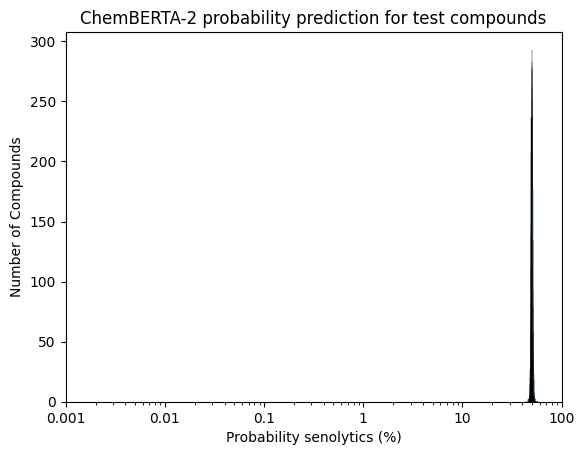

In [71]:
from matplotlib.ticker import ScalarFormatter
sns.histplot(data=test_df, x=100*test_df["prediction probability"],
    log_scale=True)

plt.title("ChemBERTA-2 probability prediction for test compounds")
plt.ylabel('Number of Compounds')
plt.xlabel('Probability senolytics (%)')
#plt.xscale('log')
#plt.xticks([0.001, 0.01, 0.1, 1, 100])  # Set label locations.)
plt.xlim([0.001, 100])
# Define the desired tick positions and labels
tick_positions = [0.001, 0.01, 0.1, 1, 10, 100]
tick_labels = ['0.001', '0.01', '0.1', '1', '10', '100']

# Set the tick positions and labels on the x-axis
plt.xticks(tick_positions, tick_labels)
plt.show()

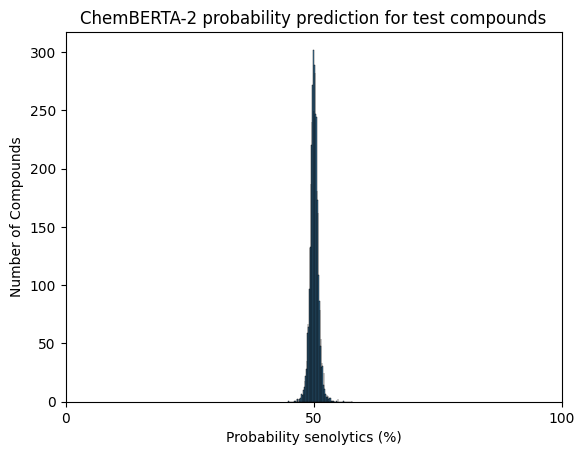

In [75]:
from matplotlib.ticker import ScalarFormatter
sns.histplot(data=test_df, x=100*test_df["prediction probability"],
    log_scale=False)

plt.title("ChemBERTA-2 probability prediction for test compounds")
plt.ylabel('Number of Compounds')
plt.xlabel('Probability senolytics (%)')
#plt.xscale('log')
plt.xticks([0, 50, 100])  # Set label locations.)
#plt.xlim([0, 100])


# Set the tick positions and labels on the x-axis
#plt.xticks(tick_positions, tick_labels)
plt.show()